In [23]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import email
import string
import random

from sklearn.base import BaseEstimator, TransformerMixin
import re
from bs4 import BeautifulSoup

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import spacy
nlp = spacy.load('en_core_web_sm')

# Data collection

In [24]:
# Function to get data from path
def extract_info(path):
    email = []
    for file in os.listdir(path):
        with open(os.path.join(path, file), encoding="ISO-8859-1") as f:
            email.append(f.read())
    return email

In [25]:
# Path from data
easy_ham_path = '/Users/alvaroanua/Documents/IIT/Fall Semester/Machine Learning/Final Project/spam_data/easy_ham/easy_ham/'
hard_ham_path = '/Users/alvaroanua/Documents/IIT/Fall Semester/Machine Learning/Final Project/spam_data/hard_ham/hard_ham/'
spam_path = '/Users/alvaroanua/Documents/IIT/Fall Semester/Machine Learning/Final Project/spam_data/spam_2/spam_2/'

In [26]:
# Get emails from each path separately
easy_ham = extract_info(easy_ham_path)
hard_ham = extract_info(hard_ham_path)
spam = extract_info(spam_path)

# Combine easy ham and hard ham
ham = easy_ham + hard_ham

# Check position 1 of ham
print(ham[0])

From rssfeeds@jmason.org  Mon Sep 30 13:43:46 2002
Return-Path: <rssfeeds@example.com>
Delivered-To: yyyy@localhost.example.com
Received: from localhost (jalapeno [127.0.0.1])
	by jmason.org (Postfix) with ESMTP id AE79816F16
	for <jm@localhost>; Mon, 30 Sep 2002 13:43:46 +0100 (IST)
Received: from jalapeno [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for jm@localhost (single-drop); Mon, 30 Sep 2002 13:43:46 +0100 (IST)
Received: from dogma.slashnull.org (localhost [127.0.0.1]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g8U81fg21359 for
    <jm@jmason.org>; Mon, 30 Sep 2002 09:01:41 +0100
Message-Id: <200209300801.g8U81fg21359@dogma.slashnull.org>
To: yyyy@example.com
From: gamasutra <rssfeeds@example.com>
Subject: Priceless Rubens works stolen in raid on mansion
Date: Mon, 30 Sep 2002 08:01:41 -0000
Content-Type: text/plain; encoding=utf-8
Lines: 6
X-Spam-Status: No, hits=-527.4 required=5.0
	tests=AWL,DATE_IN_PAST_03_06,T_URI_COUNT_0_1
	version=2.50-cvs
X-Spam

In [27]:
# Shuffle 
random.shuffle(ham)
random.shuffle(spam)

# Check if shuffle
print(ham[0])

From fork-admin@xent.com  Fri Sep  6 11:41:37 2002
Return-Path: <fork-admin@xent.com>
Delivered-To: yyyy@localhost.example.com
Received: from localhost (jalapeno [127.0.0.1])
	by jmason.org (Postfix) with ESMTP id AFF3616F70
	for <jm@localhost>; Fri,  6 Sep 2002 11:39:36 +0100 (IST)
Received: from jalapeno [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for jm@localhost (single-drop); Fri, 06 Sep 2002 11:39:36 +0100 (IST)
Received: from webnote.net (mail.webnote.net [193.120.211.219]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g868Y3W25987 for
    <jm@jmason.org>; Fri, 6 Sep 2002 09:34:33 +0100
Received: from xent.com ([64.161.22.236]) by webnote.net (8.9.3/8.9.3)
    with ESMTP id EAA20098 for <jm@jmason.org>; Fri, 6 Sep 2002 04:34:22 +0100
Received: from lair.xent.com (localhost [127.0.0.1]) by xent.com (Postfix)
    with ESMTP id B4DF82940AA; Thu,  5 Sep 2002 20:31:02 -0700 (PDT)
Delivered-To: fork@example.com
Received: from mithral.com (watcher.mithral.com [204

# Data preprocessing

In [28]:
class AdvancedTextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = PorterStemmer()

    def fit(self, X, y=None): 
        return self

    def transform(self, X):
        return [self.process_email(mail) for mail in X]

    def process_email(self, mail):
        message = email.message_from_string(mail)
        body = ""

        if message.is_multipart():
            for part in message.walk():
                if part.get_content_type() == 'text/plain':
                    body = part.get_payload(decode=True)
                    break
        else:
            body = message.get_payload(decode=True)

        text = self.clean_text(body)
        return self.advanced_nlp_processing(text)

    def clean_text(self, text):
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text().lower()
        text = re.sub(r'(https|http)?:\/\/\S+', '', text)
        text = re.sub(r'\b\w+@\w+\.\w+\b', '', text)
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = ''.join([i for i in text if not i.isdigit()])
        return text

    def advanced_nlp_processing(self, text):
        doc = nlp(text)
        entities = " ".join([ent.text for ent in doc.ents])
        pos_tags = " ".join([token.pos_ for token in doc])
        dependencies = " ".join([token.dep_ for token in doc])
        combined_features = text + " " + entities + " " + pos_tags + " " + dependencies
        return combined_features


In [29]:
# Apply advanced text processing
text_processor = AdvancedTextPreprocessor()
processed_ham = text_processor.transform(ham)
processed_spam = text_processor.transform(spam)

processed_easy_ham = text_processor.transform(easy_ham)
processed_hard_ham = text_processor.transform(hard_ham)

/var/folders/26/yv03qdk52hn4prrmhtnglhn00000gn/T/ipykernel_3339/3920964350.py:28: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
/var/folders/26/yv03qdk52hn4prrmhtnglhn00000gn/T/ipykernel_3339/3920964350.py:28: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


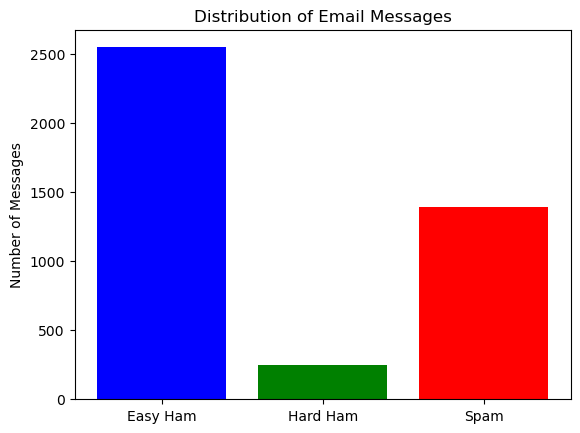

In [30]:
# Counts for each category
count_easy_ham = len(processed_easy_ham)
count_hard_ham = len(processed_hard_ham)
count_spam = len(processed_spam)

# Data for plotting
categories = ['Easy Ham', 'Hard Ham', 'Spam']
counts = [count_easy_ham, count_hard_ham, count_spam]

# Creating bar chart
plt.bar(categories, counts, color=['blue', 'green', 'red'])

# Adding labels and title
plt.title('Distribution of Email Messages')
plt.ylabel('Number of Messages')
plt.xticks(categories)

# Show the plot
plt.show()

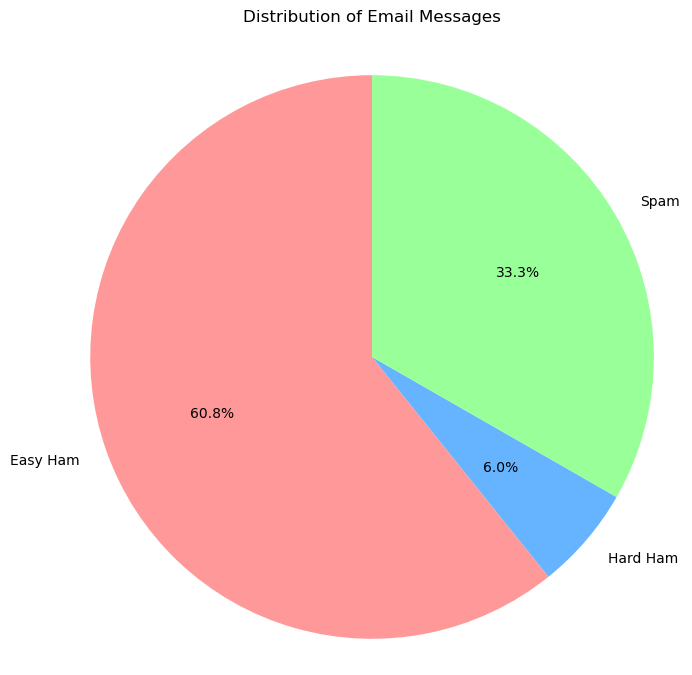

In [31]:
# Data for plotting
labels = ['Easy Ham', 'Hard Ham', 'Spam']
sizes = [count_easy_ham, count_hard_ham, count_spam]
colors = ['#ff9999','#66b3ff','#99ff99']

# Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Equal aspect ratio ensures the pie chart is circular.
plt.axis('equal')
plt.title('Distribution of Email Messages', pad=20)

# Show the plot
plt.show()

# Splitting dataset

In [32]:
from sklearn.utils import shuffle
# Random seed
random_state = 42

# Combining ham and spam data into a single dataset
X = processed_ham + processed_spam

# Creating labels (0 for ham and 1 for spam)
y = [0]*len(processed_ham) + [1]*len(processed_spam)

# Shuffle
X , y = shuffle(X, y, random_state=random_state)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state) # 20% of the data will be used for testing, and the remaining 80% will be used for training. 

# Count Vectorizer

In [33]:
vectorizer = CountVectorizer(stop_words='english')
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)
X_train = X_train_counts.toarray()
X_test = X_test_counts.toarray()
y_train = np.array(y_train).reshape(len(y_train), 1)
y_test = np.array(y_test).reshape(len(y_test), 1)

### Naive Bayes

Average Accuracy: 96.31%
Average Precision: 96.34%
Average Recall: 96.31%
Average F1 Score: 96.28%


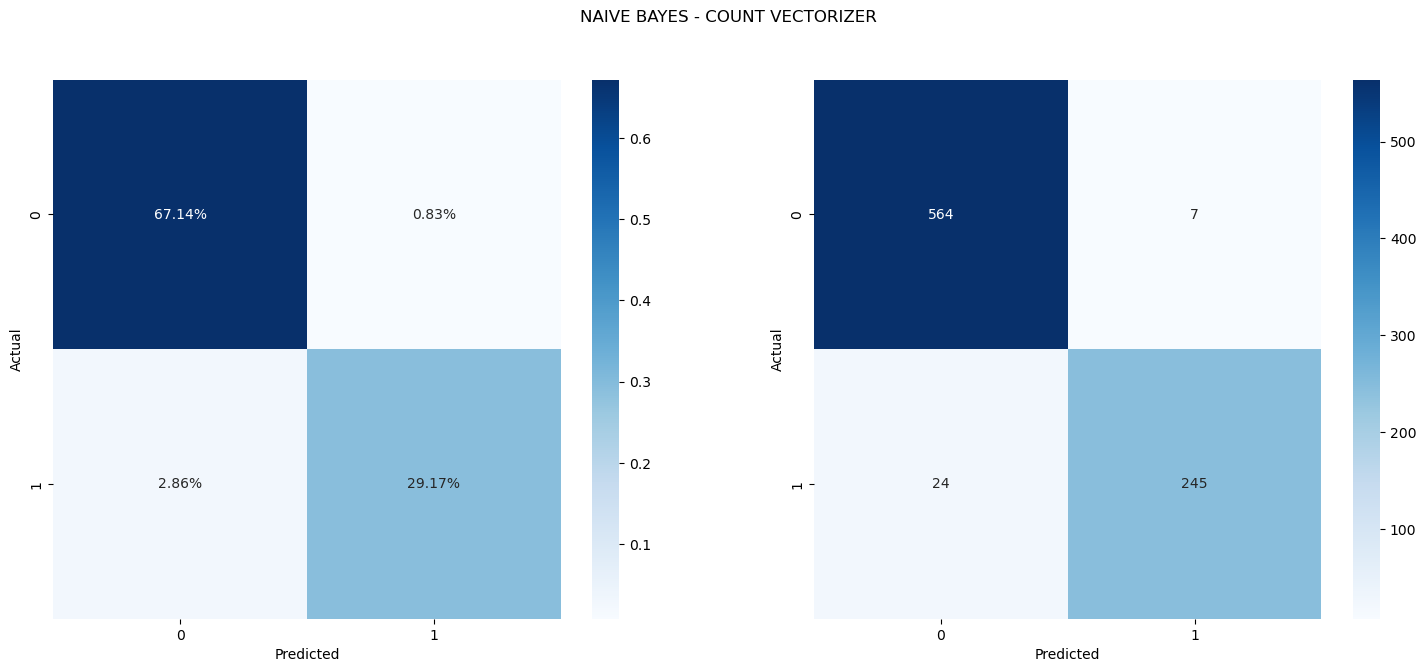

In [34]:
# Naive Bayes Classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_counts, np.ravel(y_train))

# Making predictions
predictions_nb = nb_classifier.predict(X_test_counts)

# Generando el informe de clasificación
report = classification_report(y_test, predictions_nb, output_dict=True)

# Convertir a DataFrame
report_df = pd.DataFrame(report).transpose()

# Calculate accuracy
average_accuracy = round(accuracy_score(y_test, predictions_nb) * 100, 2)
# Calcular promedios y redondear
average_precision = round(report_df.loc['weighted avg', 'precision'] * 100, 2)
average_recall = round(report_df.loc['weighted avg', 'recall'] * 100, 2)
average_f1_score = round(report_df.loc['weighted avg', 'f1-score'] * 100, 2)

# Print results
print(f"Average Accuracy: {average_accuracy}%")
print(f"Average Precision: {average_precision}%")
print(f"Average Recall: {average_recall}%")
print(f"Average F1 Score: {average_f1_score}%")

# Confusion matrix
conf_mx_nb = confusion_matrix(y_test, predictions_nb)

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,7))
fig.suptitle('NAIVE BAYES - COUNT VECTORIZER')
sns.heatmap(conf_mx_nb/np.sum(conf_mx_nb), ax=axes[0], annot=True, 
            fmt='.2%', cmap='Blues')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(conf_mx_nb, ax=axes[1], annot=True, cmap='Blues', fmt='')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.show()

### SVM

Average Accuracy: 76.67%
Average Precision: 79.2%
Average Recall: 76.67%
Average F1 Score: 72.71%


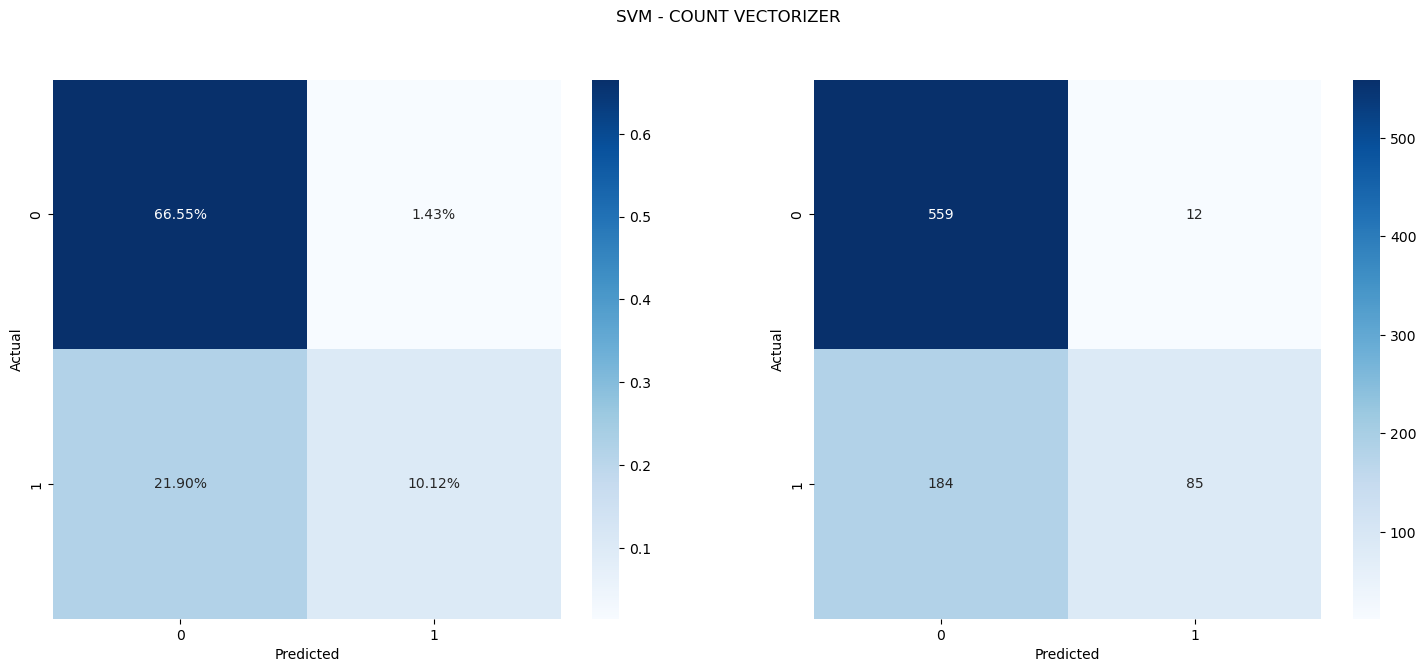

In [35]:
# SVM Classifier
svm_classifier = SVC()
svm_classifier.fit(X_train_counts, np.ravel(y_train))

# Making predictions
predictions_svm = svm_classifier.predict(X_test_counts)

# Generando el informe de clasificación
report = classification_report(y_test, predictions_svm, output_dict=True)

# Convertir a DataFrame
report_df = pd.DataFrame(report).transpose()

# Calculate accuracy
average_accuracy = round(accuracy_score(y_test, predictions_svm) * 100, 2)
# Calcular promedios y redondear
average_precision = round(report_df.loc['weighted avg', 'precision'] * 100, 2)
average_recall = round(report_df.loc['weighted avg', 'recall'] * 100, 2)
average_f1_score = round(report_df.loc['weighted avg', 'f1-score'] * 100, 2)

# Print results
print(f"Average Accuracy: {average_accuracy}%")
print(f"Average Precision: {average_precision}%")
print(f"Average Recall: {average_recall}%")
print(f"Average F1 Score: {average_f1_score}%")

# Confusion matrix
conf_mx_svm = confusion_matrix(y_test, predictions_svm)

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,7))
fig.suptitle('SVM - COUNT VECTORIZER')
sns.heatmap(conf_mx_svm/np.sum(conf_mx_svm), ax=axes[0], annot=True, 
            fmt='.2%', cmap='Blues')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(conf_mx_svm, ax=axes[1], annot=True, cmap='Blues', fmt='')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.show()

### Logistic Regression

Average accuracy: 97.5%
Average Precision: 97.5%
Average Recall: 97.5%
Average F1 Score: 97.49%


/Users/alvaroanua/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


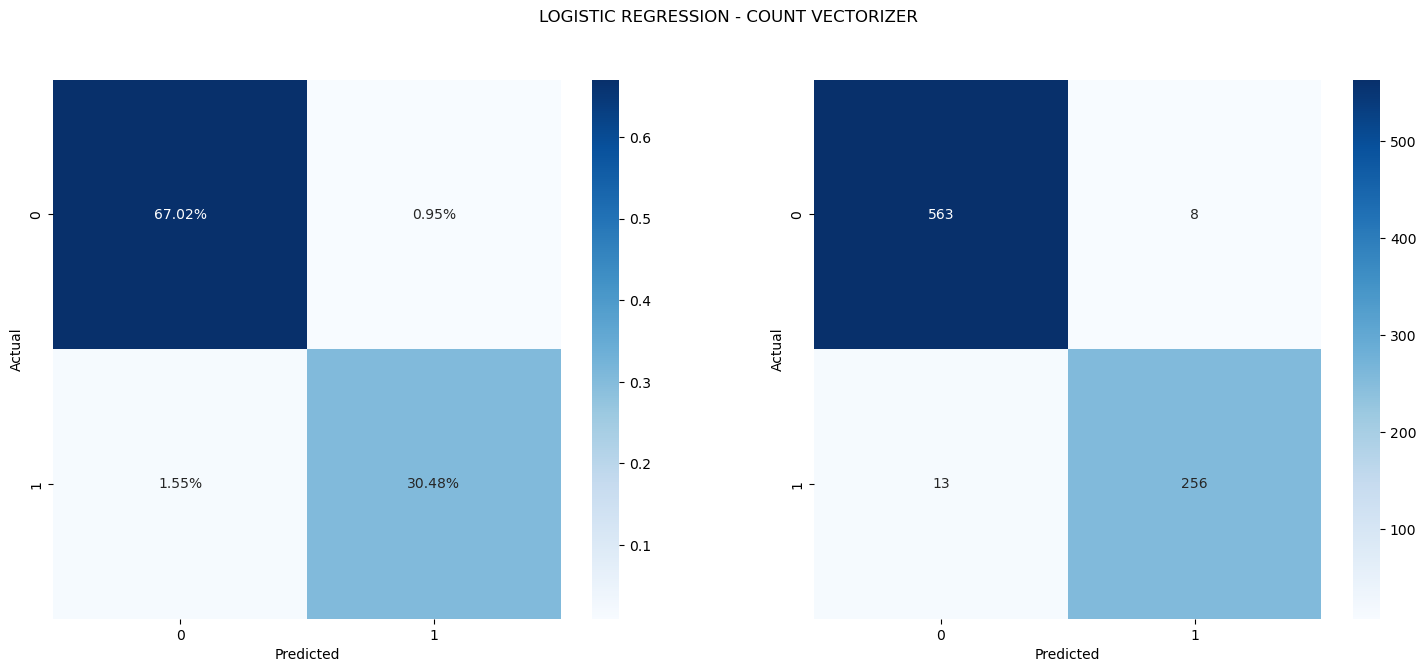

In [36]:
# Logistic Regression Classifier
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train_counts, np.ravel(y_train))

# Making predictions
predictions_lr = lr_classifier.predict(X_test_counts)

# Generando el informe de clasificación
report = classification_report(y_test, predictions_lr, output_dict=True)

# Convertir a DataFrame
report_df = pd.DataFrame(report).transpose()

# Calculate accuracy
average_accuracy = round(accuracy_score(y_test, predictions_lr) * 100, 2)
# Calcular promedios y redondear
average_precision = round(report_df.loc['weighted avg', 'precision'] * 100, 2)
average_recall = round(report_df.loc['weighted avg', 'recall'] * 100, 2)
average_f1_score = round(report_df.loc['weighted avg', 'f1-score'] * 100, 2)

# Print results
print(f"Average accuracy: {average_accuracy}%")
print(f"Average Precision: {average_precision}%")
print(f"Average Recall: {average_recall}%")
print(f"Average F1 Score: {average_f1_score}%")

# Confusion matrix
conf_mx_lr = confusion_matrix(y_test, predictions_lr)

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,7))
fig.suptitle('LOGISTIC REGRESSION - COUNT VECTORIZER')
sns.heatmap(conf_mx_lr/np.sum(conf_mx_lr), ax=axes[0], annot=True, 
            fmt='.2%', cmap='Blues')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(conf_mx_lr, ax=axes[1], annot=True, cmap='Blues', fmt='')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.show()

### Model GBM

Average Accuracy: 96.19%
Average Precision: 96.19%
Average Recall: 96.19%
Average F1 Score: 96.17%


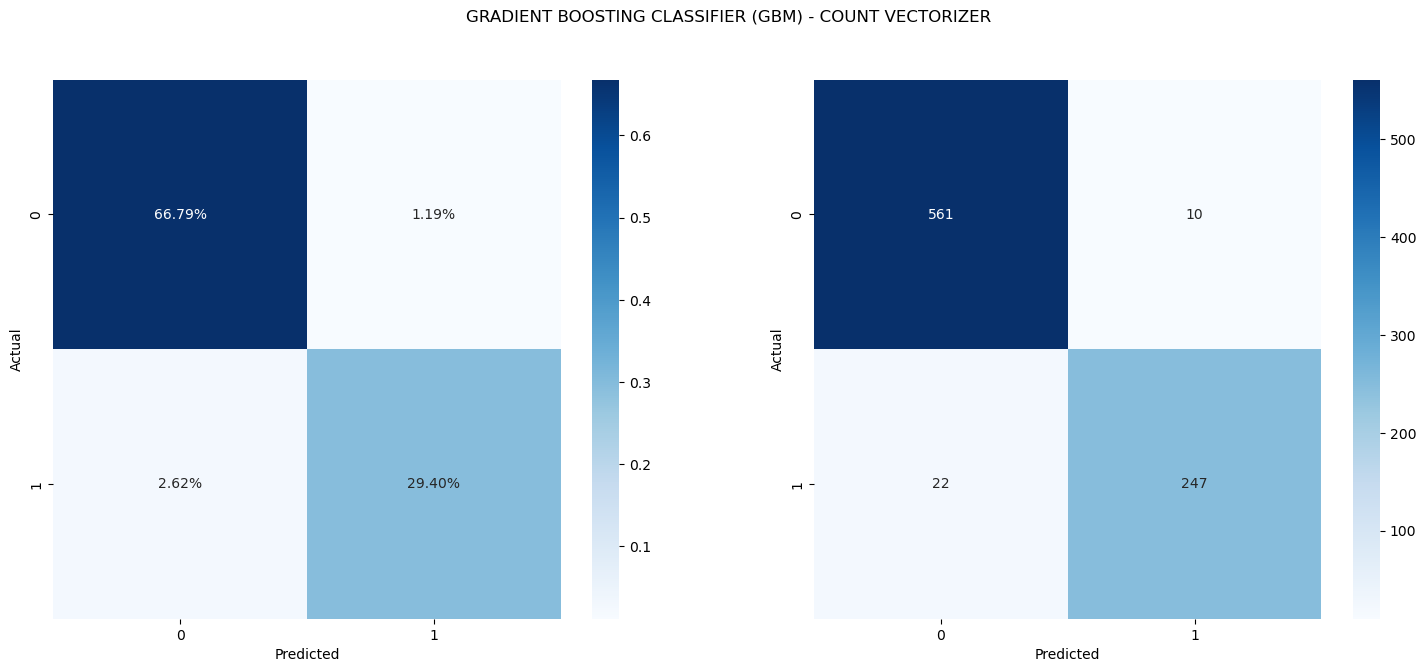

In [37]:
# Gradient Boosting Classifier
gbm_classifier = GradientBoostingClassifier()
gbm_classifier.fit(X_train_counts, np.ravel(y_train))

# Making predictions
predictions_gbm = gbm_classifier.predict(X_test_counts)

# Generando el informe de clasificación
report = classification_report(y_test, predictions_gbm, output_dict=True)

# Convertir a DataFrame
report_df = pd.DataFrame(report).transpose()

# Calculate accuracy
average_accuracy = round(accuracy_score(y_test, predictions_gbm) * 100, 2)
# Calcular promedios y redondear
average_precision = round(report_df.loc['weighted avg', 'precision'] * 100, 2)
average_recall = round(report_df.loc['weighted avg', 'recall'] * 100, 2)
average_f1_score = round(report_df.loc['weighted avg', 'f1-score'] * 100, 2)

# Print results
print(f"Average Accuracy: {average_accuracy}%")
print(f"Average Precision: {average_precision}%")
print(f"Average Recall: {average_recall}%")
print(f"Average F1 Score: {average_f1_score}%")

# Confusion matrix
conf_mx_gbm = confusion_matrix(y_test, predictions_gbm)

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,7))
fig.suptitle('GRADIENT BOOSTING CLASSIFIER (GBM) - COUNT VECTORIZER')
sns.heatmap(conf_mx_gbm/np.sum(conf_mx_gbm), ax=axes[0], annot=True, 
            fmt='.2%', cmap='Blues')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(conf_mx_gbm, ax=axes[1], annot=True, cmap='Blues', fmt='')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.show()

### Model Random Forest

/Users/alvaroanua/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Average Accuracy: 97.02%
Average Precision: 97.02%
Average Recall: 97.02%
Average F1 Score: 97.01%


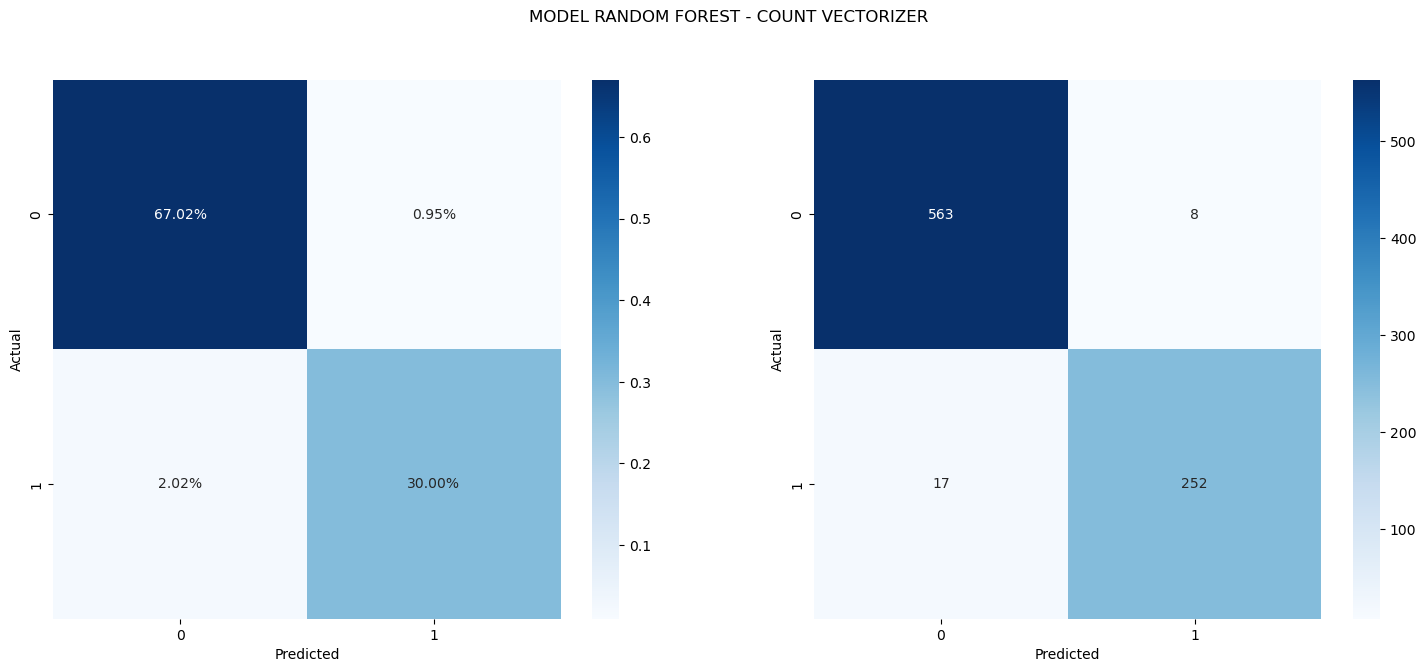

In [38]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=1200)
rfc.fit(X_train, y_train)
predictions_rfc = rfc.predict(X_test)

# Generando el informe de clasificación
report = classification_report(y_test, predictions_rfc, output_dict=True)

# Convertir a DataFrame
report_df = pd.DataFrame(report).transpose()

# Calculate accuracy
average_accuracy = round(accuracy_score(y_test, predictions_rfc) * 100, 2)
# Calcular promedios y redondear
average_precision = round(report_df.loc['weighted avg', 'precision'] * 100, 2)
average_recall = round(report_df.loc['weighted avg', 'recall'] * 100, 2)
average_f1_score = round(report_df.loc['weighted avg', 'f1-score'] * 100, 2)

# Print results
print(f"Average Accuracy: {average_accuracy}%")
print(f"Average Precision: {average_precision}%")
print(f"Average Recall: {average_recall}%")
print(f"Average F1 Score: {average_f1_score}%")

# Confusion matrix
conf_mx_rfc = confusion_matrix(y_test, predictions_rfc)

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,7))
fig.suptitle('MODEL RANDOM FOREST - COUNT VECTORIZER')
sns.heatmap(conf_mx_rfc/np.sum(conf_mx_rfc), ax=axes[0], annot=True, 
            fmt='.2%', cmap='Blues')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(conf_mx_rfc, ax=axes[1], annot=True, cmap='Blues', fmt='')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.show()

# Tfidf Vectorizer

In [39]:
# Random seed
random_state = 42

# Combining ham and spam data into a single dataset
X = processed_ham + processed_spam

# Creating labels (0 for ham and 1 for spam)
y = [0]*len(processed_ham) + [1]*len(processed_spam)

# Shuffle
X , y = shuffle(X, y, random_state=random_state)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state) # 20% of the data will be used for testing, and the remaining 80% will be used for training. 

# Create a TfidfVectorizer instance with English stop words
vectorizer = TfidfVectorizer(stop_words='english')

# Fit the vectorizer to the training data and transform the training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform the testing data
X_test_tfidf = vectorizer.transform(X_test)

### Naive Bayes

Average Accuracy: 71.43%
Average Precision: 79.88%
Average Recall: 71.43%
Average F1 Score: 62.4%


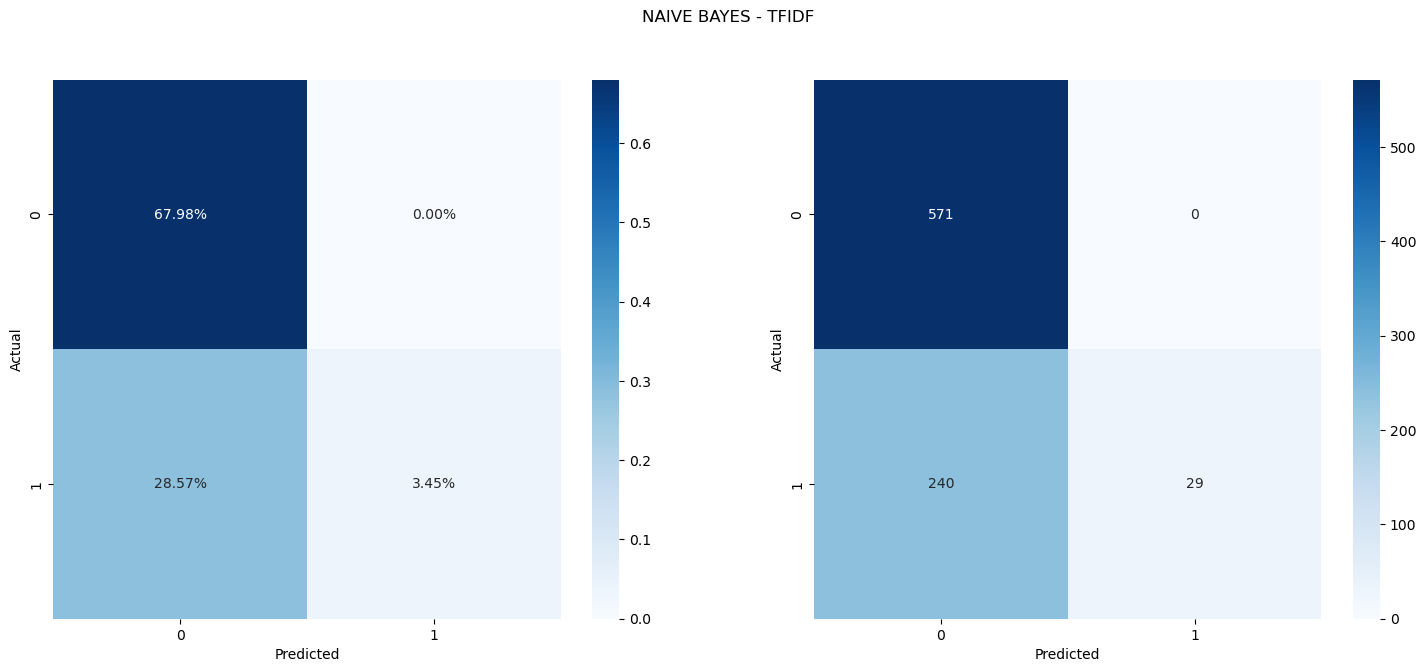

In [40]:
# Naive Bayes Classifier
nb_classifier_tf = MultinomialNB()
nb_classifier_tf.fit(X_train_tfidf, np.ravel(y_train))

# Making predictions
predictions_nb_tf = nb_classifier_tf.predict(X_test_tfidf)

# Generando el informe de clasificación
report = classification_report(y_test, predictions_nb_tf, output_dict=True)

# Convertir a DataFrame
report_df = pd.DataFrame(report).transpose()

# Calculate accuracy
average_accuracy = round(accuracy_score(y_test, predictions_nb_tf) * 100, 2)
# Calcular promedios y redondear
average_precision = round(report_df.loc['weighted avg', 'precision'] * 100, 2)
average_recall = round(report_df.loc['weighted avg', 'recall'] * 100, 2)
average_f1_score = round(report_df.loc['weighted avg', 'f1-score'] * 100, 2)

# Print results
print(f"Average Accuracy: {average_accuracy}%")
print(f"Average Precision: {average_precision}%")
print(f"Average Recall: {average_recall}%")
print(f"Average F1 Score: {average_f1_score}%")

# Confusion matrix
conf_mx_nb_tf = confusion_matrix(y_test, predictions_nb_tf)

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,7))
fig.suptitle('NAIVE BAYES - TFIDF')
sns.heatmap(conf_mx_nb_tf/np.sum(conf_mx_nb_tf), ax=axes[0], annot=True, 
            fmt='.2%', cmap='Blues')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(conf_mx_nb_tf, ax=axes[1], annot=True, cmap='Blues', fmt='')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.show()

### SVM

Average Accuracy: 97.14%
Average Precision: 97.14%
Average Recall: 97.14%
Average F1 Score: 97.13%


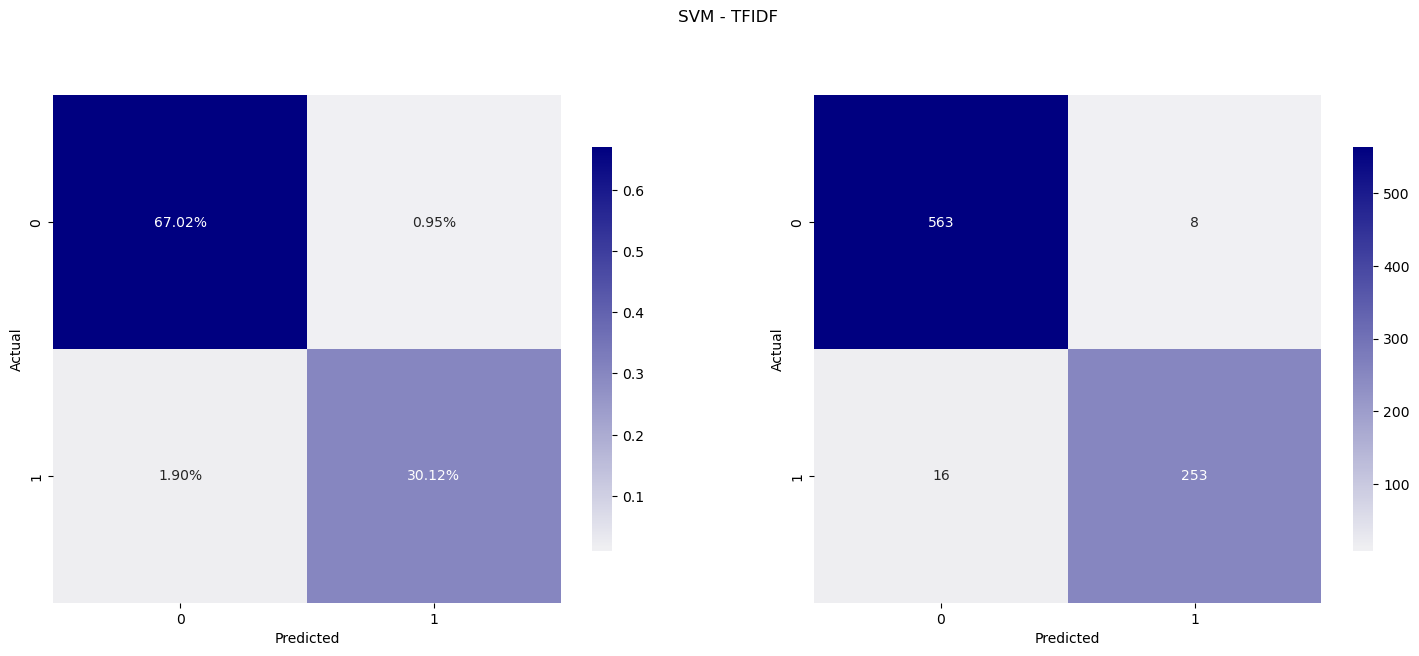

In [41]:
# SVM Classifier
svm_classifier_tf = SVC()
svm_classifier_tf.fit(X_train_tfidf, np.ravel(y_train))

# Making predictions
predictions_svm_tf = svm_classifier_tf.predict(X_test_tfidf)

# Generando el informe de clasificación
report = classification_report(y_test, predictions_svm_tf, output_dict=True)

# Convertir a DataFrame
report_df = pd.DataFrame(report).transpose()

# Calculate accuracy
average_accuracy = round(accuracy_score(y_test, predictions_svm_tf) * 100, 2)
# Calcular promedios y redondear
average_precision = round(report_df.loc['weighted avg', 'precision'] * 100, 2)
average_recall = round(report_df.loc['weighted avg', 'recall'] * 100, 2)
average_f1_score = round(report_df.loc['weighted avg', 'f1-score'] * 100, 2)

# Print results
print(f"Average Accuracy: {average_accuracy}%")
print(f"Average Precision: {average_precision}%")
print(f"Average Recall: {average_recall}%")
print(f"Average F1 Score: {average_f1_score}%")

# Confusion matrix
conf_mx_svm_tf = confusion_matrix(y_test, predictions_svm_tf)

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,7))
fig.suptitle('SVM - TFIDF')

# Usando una paleta de colores personalizada con tonos grises y azules
custom_palette = sns.light_palette("navy", as_cmap=True)

sns.heatmap(conf_mx_svm_tf/np.sum(conf_mx_svm_tf), ax=axes[0], annot=True, 
            fmt='.2%', cmap=custom_palette, square=True, cbar_kws={"shrink": .75})
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(conf_mx_svm_tf, ax=axes[1], annot=True, cmap=custom_palette, fmt='', 
            square=True, cbar_kws={"shrink": .75})
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.show()

### Logistic Regresion

Average Accuracy: 93.81
Average Precision: 93.97%
Average Recall: 93.81%
Average F1 Score: 93.68%


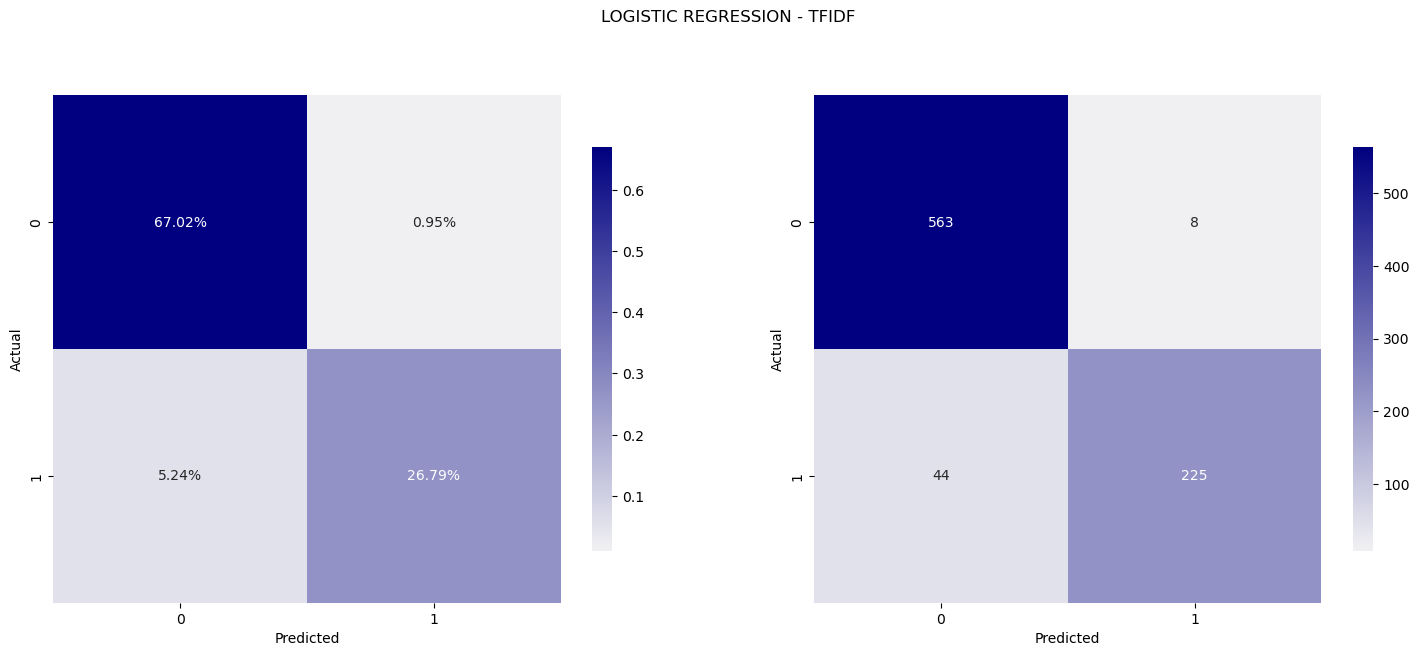

In [42]:
# Logistic Regression Classifier
lr_classifier_tf = LogisticRegression()
lr_classifier_tf.fit(X_train_tfidf, np.ravel(y_train))

# Making predictions
predictions_lr_tf = lr_classifier_tf.predict(X_test_tfidf)

# Generando el informe de clasificación
report = classification_report(y_test, predictions_lr_tf, output_dict=True)

# Convertir a DataFrame
report_df = pd.DataFrame(report).transpose()

# Calculate accuracy
average_accuracy = round(accuracy_score(y_test, predictions_lr_tf) * 100, 2)
# Calcular promedios y redondear
average_precision = round(report_df.loc['weighted avg', 'precision'] * 100, 2)
average_recall = round(report_df.loc['weighted avg', 'recall'] * 100, 2)
average_f1_score = round(report_df.loc['weighted avg', 'f1-score'] * 100, 2)

# Print results
print(f"Average Accuracy: {average_accuracy}")
print(f"Average Precision: {average_precision}%")
print(f"Average Recall: {average_recall}%")
print(f"Average F1 Score: {average_f1_score}%")

# Confusion matrix
conf_mx_lr_tf = confusion_matrix(y_test, predictions_lr_tf)

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,7))
fig.suptitle('LOGISTIC REGRESSION - TFIDF')

# Usando una paleta de colores personalizada con tonos grises y azules
custom_palette = sns.light_palette("navy", as_cmap=True)

sns.heatmap(conf_mx_lr_tf/np.sum(conf_mx_lr_tf), ax=axes[0], annot=True, 
            fmt='.2%', cmap=custom_palette, square=True, cbar_kws={"shrink": .75})
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(conf_mx_lr_tf, ax=axes[1], annot=True, cmap=custom_palette, fmt='', 
            square=True, cbar_kws={"shrink": .75})
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.show()

### GBM

Average Accuracy: 96.67%
Average Precision: 96.66%
Average Recall: 96.67%
Average F1 Score: 96.65%


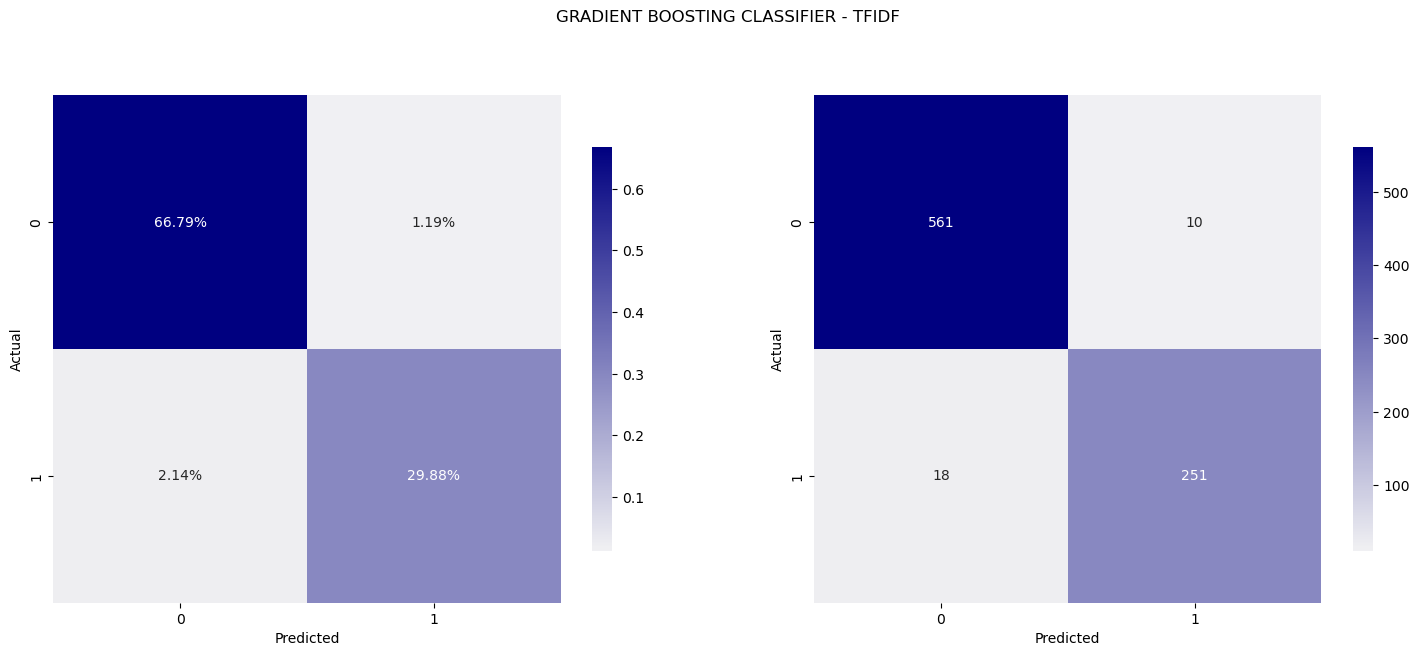

In [43]:
# Gradient Boosting Classifier
gbm_classifier_tf = GradientBoostingClassifier()
gbm_classifier_tf.fit(X_train_tfidf, np.ravel(y_train))

# Making predictions
predictions_gbm_tf= gbm_classifier_tf.predict(X_test_tfidf)

# Generando el informe de clasificación
report = classification_report(y_test, predictions_gbm_tf, output_dict=True)

# Convertir a DataFrame
report_df = pd.DataFrame(report).transpose()

# Calculate accuracy
average_accuracy = round(accuracy_score(y_test, predictions_gbm_tf) * 100, 2)
# Calcular promedios y redondear
average_precision = round(report_df.loc['weighted avg', 'precision'] * 100, 2)
average_recall = round(report_df.loc['weighted avg', 'recall'] * 100, 2)
average_f1_score = round(report_df.loc['weighted avg', 'f1-score'] * 100, 2)

# Print results
print(f"Average Accuracy: {average_accuracy}%")
print(f"Average Precision: {average_precision}%")
print(f"Average Recall: {average_recall}%")
print(f"Average F1 Score: {average_f1_score}%")

# Confusion matrix
conf_mx_gbm_tf = confusion_matrix(y_test, predictions_gbm_tf)

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,7))
fig.suptitle('GRADIENT BOOSTING CLASSIFIER - TFIDF')

# Usando una paleta de colores personalizada con tonos grises y azules
custom_palette = sns.light_palette("navy", as_cmap=True)

sns.heatmap(conf_mx_gbm_tf/np.sum(conf_mx_gbm_tf), ax=axes[0], annot=True, 
            fmt='.2%', cmap=custom_palette, square=True, cbar_kws={"shrink": .75})
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(conf_mx_gbm_tf, ax=axes[1], annot=True, cmap=custom_palette, fmt='', 
            square=True, cbar_kws={"shrink": .75})
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.show()

### Random Forest

Average Accuracy: 97.02%
Average Precision: 97.03%
Average Recall: 97.02%
Average F1 Score: 97.01%


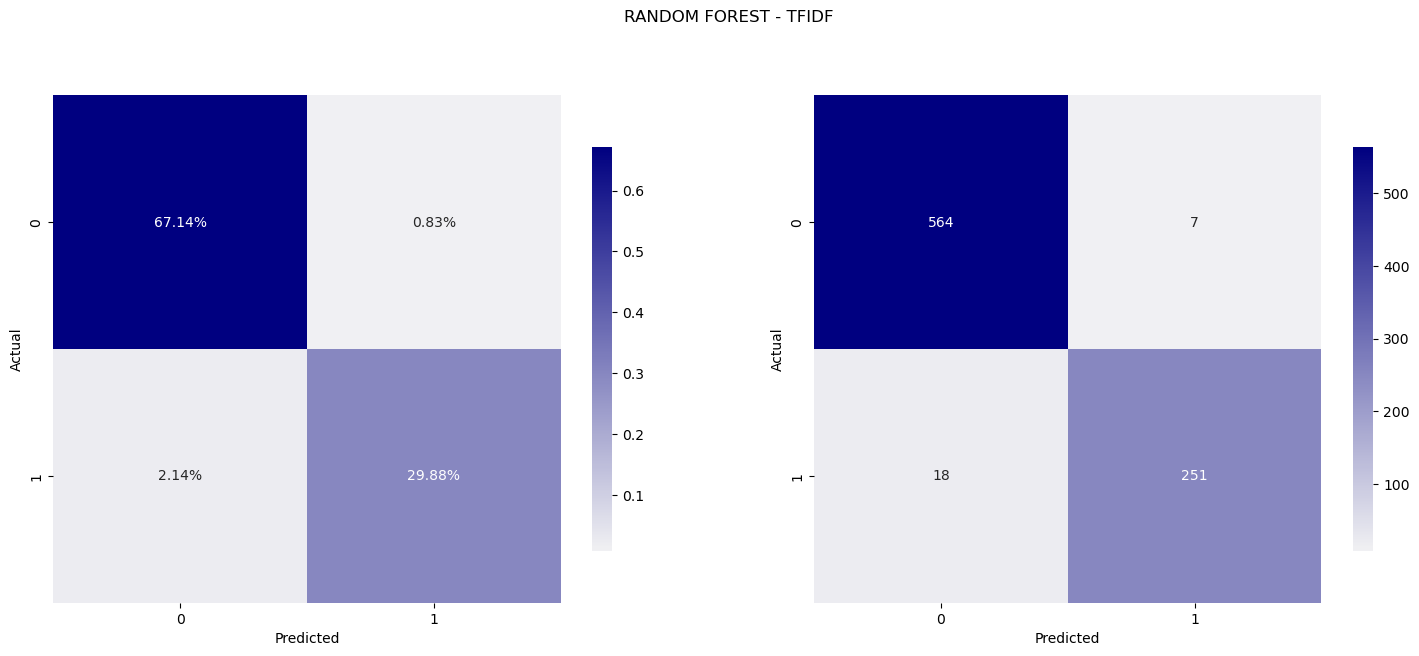

In [44]:
# Training the Random Forest Classifier
rfc_tf = RandomForestClassifier(n_estimators=1200)
rfc_tf.fit(X_train_tfidf, np.ravel(y_train))

# Making predictions
predictions_rfc_tf = rfc_tf.predict(X_test_tfidf)

# Generando el informe de clasificación
report = classification_report(y_test, predictions_rfc_tf, output_dict=True)

# Convertir a DataFrame
report_df = pd.DataFrame(report).transpose()

# Calculate accuracy
average_accuracy = round(accuracy_score(y_test, predictions_rfc_tf) * 100, 2)
# Calcular promedios y redondear
average_precision = round(report_df.loc['weighted avg', 'precision'] * 100, 2)
average_recall = round(report_df.loc['weighted avg', 'recall'] * 100, 2)
average_f1_score = round(report_df.loc['weighted avg', 'f1-score'] * 100, 2)

# Print results
print(f"Average Accuracy: {average_accuracy}%")
print(f"Average Precision: {average_precision}%")
print(f"Average Recall: {average_recall}%")
print(f"Average F1 Score: {average_f1_score}%")

# Suponiendo que y_test y predictions_rfc_tf están definidos y contienen los datos relevantes.
conf_mx_rfc_tf = confusion_matrix(y_test, predictions_rfc_tf)

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,7))
fig.suptitle('RANDOM FOREST - TFIDF')

# Usando una paleta de colores personalizada con tonos grises y azules
custom_palette = sns.light_palette("navy", as_cmap=True)

sns.heatmap(conf_mx_rfc_tf/np.sum(conf_mx_rfc_tf), ax=axes[0], annot=True, 
            fmt='.2%', cmap=custom_palette, square=True, cbar_kws={"shrink": .75})
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(conf_mx_rfc_tf, ax=axes[1], annot=True, cmap=custom_palette, fmt='', 
            square=True, cbar_kws={"shrink": .75})
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.show()